# Week 1 : Systematically Improving Your RAG Application

## Retrieval Evals

> If you have not already, please run the `1. synthetic_questions.ipynb` notebook to generate the synthetic questions we'll be using in this notebook before proceeding.

After generating the synthetic questions, we'll use them to benchmark the recall and mrr of various retrieval methods. We'll do so by varying different components of our retrieval pipeline such as

1. **Search Method** : Hybrid Search and Embedding Search
2. **Using a Re-Ranker** : We'll compare the effectiveness of using a reranker vs not using a reranker
3. **Embedding Models** : We'll compare the difference in performance between using OpenAI's `text-embedding-3-small` vs `text-embedding-3-large`

By having an objective way to measure the performance of each retrieval method, we can start to make an informed decision about which to use. For instance, if we get a 1% improvement in recall@10 but latency increases by 10x by introducing a re-ranker, we might not want to do so. 

We'll do this in three steps

1. First, we'll take our original dataset of sql snippets from `567-labs/bird-rag` and ingest it into a local lancedb instance.
2. Then we'll compute the recall and mrr of each retrieval method
3. Finally, we'll show you how to compare different retrieval methods 

Recall that in our original dataset, each row had the following columns

- `id`: The unique identifier for each SQL snippet
- `query`: The SQL snippet
- `difficulty`: The difficulty of the question

When we query our database with a synthetic question, we'll retrieve a list of sql snippets and their ids that match the query. Our goal here is to verify that we're able to retrieve the correct id for each question.

We'll be using `braintrust` to collect the data and discuss the trade offs of each method. We like `braintrust` because it allows us to easily run multiple experiments using a simple `Eval` object and share the results easily if you're working with a team.


## Setting up Our Retrieval Pipeline

In this example, we're using a local `lancedb` instance. We're doing so because of 3 reasons.

1. LanceDB handles the embeddings of our data for us 
2. It provides embedding search, hybrid search and other re-ranking methods all within a single api.
3. We can use Pydantic to define our table schema and easily ingest our data.

This makes it quick and easy for us to compare the performance of each method.

In [3]:
import datasets
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.table import Table


def get_or_create_lancedb_table(db: Table, table_name: str, embedding_model: str):
    if table_name in db.table_names():
        print(f"Table {table_name} already exists")
        return db.open_table(table_name)

    func = get_registry().get("openai").create(name=embedding_model)

    class Chunk(LanceModel):
        id: str
        query: str = func.SourceField()
        vector: Vector(func.ndims()) = func.VectorField()

    table = db.create_table(table_name, schema=Chunk, mode="overwrite")
    dataset = datasets.load_dataset("567-labs/bird-rag")["train"]
    formatted_dataset = [{"id": item["id"], "query": item["query"]} for item in dataset]

    table.create_fts_index("query", replace=True)
    print(f"{table.count_rows()} chunks ingested into the database")
    return table


# Create LanceDB Instance
db = lancedb.connect("./lancedb")
table_small = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_small", "text-embedding-3-small"
)
table_large = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_large", "text-embedding-3-large"
)

Table chunks_text_embedding_3_small already exists
Table chunks_text_embedding_3_large already exists


## Defining Metrics

Let's now start by evaluating the retrieval performance of our model. We'll do so by measuring the recall and MRR at different levels of k.

$$ \text{Recall} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Relevant Items}} $$ 

$$ \text{MRR} = \frac{\sum_{i=1}^{n} \frac{1}{rank(i)}}{n} $$ 

As models improve, their context window and reasoning abilities improve. This means that their ability to select relevant information in response to a user query will improve. By optimizing for recall, we ensure that the language model has access to all necessary information, which can lead to more accurate and reliable generated responses.

MRR@K is a useful metric if we want to display retrieved results as citations to users. We normally show a smaller list of retrieved results to users and we want to make sure that the correct result is ranked highly during retrieval so that it's more likely to be selected.

In [4]:
def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)

## Parameterizing Your Retrieval

Now that we have a vector database with our data inside, we will now use it to evaluate different retrieval methods. Because LanceDB gives us the ability to use different retrieval methods in a single API, we can define a single `retrieve` function that can be easily modified to use different retrieval methods.

Once we've done so, we'll iterate over different subsets of the retrievewd items and compute the recall and mrr metrics. To log these scores to braintrust, we'll need to use the `Score` object.

In [20]:
from braintrust import Score
from lancedb.rerankers import CohereReranker
import lancedb
from lancedb.table import Table
from lancedb.rerankers import Reranker
from typing import Literal, Optional

db = lancedb.connect("./lancedb")
# Define Our Metrics
metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]


def retrieve(
    question: str,
    table: Table,
    max_k=25,
    mode: Literal["vector", "fts", "hybrid"] = "vector",
    reranker: Optional[Reranker] = None,
    hooks=None,
):
    results = table.search(question, query_type=mode).limit(max_k)
    if reranker:
        results = results.rerank(reranker=reranker)
    return [
        {"id": result["id"], "query": result["query"]} for result in results.to_list()
    ]


# Similar to our previous section, we can use the id of each item to compute the recall and MRR metrics.
def evaluate_braintrust(input, output, **kwargs):
    # We first get the predictions ( what we retrieved ) and the labels
    predictions = [item["id"] for item in output]
    labels = [kwargs["metadata"]["chunk_id"]]

    scores = []
    for metric, score_fn in metrics:
        for subset_k in k:
            scores.append(
                Score(
                    name=f"{metric}@{subset_k}",
                    score=score_fn(predictions[:subset_k], labels),
                    metadata={"query": input, "result": output, **kwargs["metadata"]},
                )
            )

    return scores

We want to understand how each method performs when we vary the size of retrieve items with respect to recall and mrr. This helps us understand if a method is worth the cost and latency to implement. 

More practically, if a cheaper method has a recall@10 that's equivalent to a more expensive's method recall@5, then it might be worth it to start with the cheaper method first. Using these objective metrics, we can make an informed decision about which method to use. Let's see how we can do so with a simple example below.


In [21]:
from braintrust import init_dataset, Eval
from itertools import product
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions")
][:40]

# Evaluation configurations
available_rerankers = {
    "rerank-english-v3.0": CohereReranker(
        model_name="rerank-english-v3.0", column="query"
    ),
    "none": None,
}

search_query_modes = ["hybrid", "vector"]

embedding_model_to_table = {
    "text-embedding-3-small": table_small,
    "text-embedding-3-large": table_large,
}

# Run evaluations
evaluation_results = []
experiment_id = str(uuid.uuid4())
for reranker_name, search_mode, embedding_model in product(
    available_rerankers, search_query_modes, embedding_model_to_table
):
    # Get model instances
    current_reranker = available_rerankers[reranker_name]
    current_table = embedding_model_to_table[embedding_model]

    # Configure retrieval size
    retrieval_limit = 120 if current_reranker else 40

    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"{experiment_id}-{reranker_name}-{search_mode}-{embedding_model}",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=current_table,
            mode=search_mode,
            reranker=current_reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "embedding_model": embedding_model,
            "reranker": reranker_name,
            "query_mode": search_mode,
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        evaluation_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "reranker": reranker_name,
                "embedding_model": embedding_model,
                "query_type": search_mode,
                "score": score_data.score,
            }
        )

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-small
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-small] (data): 40it [00:00, 88069.38it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-s…


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-small compared to add-braintrust-support-1730101527:
57.50% (-05.00%) 'mrr@1'     score	(6 improvements, 8 regressions)
61.67% (-13.33%) 'mrr@3'     score	(6 improvements, 14 regressions)
63.79% (-11.21%) 'mrr@5'     score	(7 improvements, 14 regressions)
65.86% (-10.01%) 'mrr@10'    score	(8 improvements, 15 regressions)
66.07% (-09.99%) 'mrr@15'    score	(8 improvements, 15 regressions)
66.07% 'mrr@20'    score
66.17% (-09.89%) 'mrr@25'    score	(8 improvements, 15 regressions)
66.17% 'mrr@30'    score
66.17% 'mrr@35'    score
66.24% (-09.82%) 'mrr@40'    score	(8 improvements, 15 regressions)
57.50% (-05.00%) 'recall@1'  score	(6 improvements, 8 regressions)
67.50% (-22.50%) 'recall@3'  score	(1 improvements, 10 regressions)
77.50% (-12.50%) 'recall@5'  score	(2 improvements, 7 regressions)
92.50% (-05.00%) 'recall@10' score	(1 improvements, 3 r

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-large
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-large] (data): 40it [00:00, 37315.87it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-l…


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-large compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-small:
57.50% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
61.67% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
63.79% (-) 'mrr@5'     score	(0 improvements, 0 regressions)
65.90% (+00.04%) 'mrr@10'    score	(1 improvements, 0 regressions)
66.13% (+00.06%) 'mrr@15'    score	(2 improvements, 0 regressions)
66.13% (+00.06%) 'mrr@20'    score	(2 improvements, 0 regressions)
66.23% (+00.06%) 'mrr@25'    score	(2 improvements, 1 regressions)
66.23% (+00.06%) 'mrr@30'    score	(2 improvements, 1 regressions)
66.23% (+00.06%) 'mrr@35'    score	(2 improvements, 1 regressions)
66.30% (+00.06%) 'mrr@40'    score	(2 improvements, 1 regressions)
57.50% (-) 'recall@1'  score	(0 improvements, 0 regressions)
67.50% (-) 'recall@3'  score	(0 improveme

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-small
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-small] (data): 40it [00:00, 32158.74it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-s…


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-small compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-hybrid-text-embedding-3-large:
57.50% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
61.67% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
63.92% (+00.12%) 'mrr@5'     score	(1 improvements, 0 regressions)
65.98% (+00.08%) 'mrr@10'    score	(1 improvements, 1 regressions)
66.19% (+00.06%) 'mrr@15'    score	(1 improvements, 2 regressions)
66.19% (+00.06%) 'mrr@20'    score	(1 improvements, 2 regressions)
66.30% (+00.07%) 'mrr@25'    score	(2 improvements, 2 regressions)
66.30% (+00.07%) 'mrr@30'    score	(2 improvements, 2 regressions)
66.38% (+00.14%) 'mrr@35'    score	(3 improvements, 2 regressions)
66.38% (+00.07%) 'mrr@40'    score	(3 improvements, 2 regressions)
57.50% (-) 'recall@1'  score	(0 improvements, 0 regressions)
67.50% (-) 'recall@3'  score	(0 imp

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-large
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-large] (data): 40it [00:00, 32545.52it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-l…


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-large compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-small:
57.50% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
61.67% (-) 'mrr@3'     score	(0 improvements, 0 regressions)
63.92% (-) 'mrr@5'     score	(0 improvements, 0 regressions)
66.03% (+00.04%) 'mrr@10'    score	(1 improvements, 0 regressions)
66.25% (+00.06%) 'mrr@15'    score	(2 improvements, 0 regressions)
66.25% (+00.06%) 'mrr@20'    score	(2 improvements, 0 regressions)
66.36% (+00.06%) 'mrr@25'    score	(2 improvements, 1 regressions)
66.36% (+00.06%) 'mrr@30'    score	(2 improvements, 1 regressions)
66.43% (+00.06%) 'mrr@35'    score	(2 improvements, 1 regressions)
66.43% (+00.06%) 'mrr@40'    score	(2 improvements, 1 regressions)
57.50% (-) 'recall@1'  score	(0 improvements, 0 regressions)
67.50% (-) 'recall@3'  score	(0 improveme

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small] (data): 40it [00:00, 40850.29it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small] (tasks): …


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-rerank-english-v3.0-vector-text-embedding-3-large:
45.00% (-12.50%) 'mrr@1'     score	(5 improvements, 10 regressions)
50.83% (-10.83%) 'mrr@3'     score	(5 improvements, 13 regressions)
52.96% (-10.96%) 'mrr@5'     score	(6 improvements, 16 regressions)
53.95% (-12.08%) 'mrr@10'    score	(7 improvements, 19 regressions)
54.76% (-11.50%) 'mrr@15'    score	(7 improvements, 19 regressions)
54.90% (-11.35%) 'mrr@20'    score	(7 improvements, 19 regressions)
54.90% (-11.46%) 'mrr@25'    score	(7 improvements, 20 regressions)
55.08% (-11.28%) 'mrr@30'    score	(7 improvements, 20 regressions)
55.16% (-11.28%) 'mrr@35'    score	(7 improvements, 20 regressions)
55.23% (-11.21%) 'mrr@40'    score	(7 improvements, 20 regressions)
45.00% (-12.50%) 'recall@1'  score	(5 improvements, 10 regressions)
57.50% (-10.00%) 'rec

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large] (data): 40it [00:00, 33621.68it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large] (tasks): …


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-small:
55.00% (+10.00%) 'mrr@1'     score	(5 improvements, 1 regressions)
62.08% (+11.25%) 'mrr@3'     score	(10 improvements, 1 regressions)
64.33% (+11.38%) 'mrr@5'     score	(14 improvements, 1 regressions)
65.11% (+11.16%) 'mrr@10'    score	(16 improvements, 1 regressions)
65.67% (+10.91%) 'mrr@15'    score	(19 improvements, 1 regressions)
65.67% (+10.76%) 'mrr@20'    score	(19 improvements, 1 regressions)
65.77% (+10.87%) 'mrr@25'    score	(20 improvements, 1 regressions)
65.86% (+10.78%) 'mrr@30'    score	(21 improvements, 1 regressions)
65.86% (+10.70%) 'mrr@35'    score	(21 improvements, 1 regressions)
65.86% (+10.64%) 'mrr@40'    score	(21 improvements, 1 regressions)
55.00% (+10.00%) 'recall@1'  score	(5 improvements, 1 regressions)
72.50% (+15.00%) 'recall@3'  score	(6 

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small] (data): 40it [00:00, 26108.33it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small] (tasks): …


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-hybrid-text-embedding-3-large:
25.00% (-30.00%) 'mrr@1'     score	(2 improvements, 14 regressions)
38.75% (-23.33%) 'mrr@3'     score	(3 improvements, 19 regressions)
41.00% (-23.33%) 'mrr@5'     score	(4 improvements, 21 regressions)
43.77% (-21.33%) 'mrr@10'    score	(5 improvements, 22 regressions)
44.37% (-21.30%) 'mrr@15'    score	(8 improvements, 22 regressions)
44.50% (-21.16%) 'mrr@20'    score	(9 improvements, 22 regressions)
44.61% (-21.16%) 'mrr@25'    score	(9 improvements, 22 regressions)
44.61% (-21.25%) 'mrr@30'    score	(9 improvements, 22 regressions)
44.61% (-21.25%) 'mrr@35'    score	(9 improvements, 22 regressions)
44.61% (-21.25%) 'mrr@40'    score	(9 improvements, 22 regressions)
25.00% (-30.00%) 'recall@1'  score	(2 improvements, 14 regressions)
55.00% (-17.50%) 'recall@3'  score	(

Experiment 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large
Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large] (data): 40it [00:00, 25823.02it/s]


Text-2-SQL [experiment_name=7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large] (tasks): …


=========================SUMMARY=========================
7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large compared to 7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small:
62.50% (+37.50%) 'mrr@1'     score	(16 improvements, 1 regressions)
75.00% (+36.25%) 'mrr@3'     score	(23 improvements, 2 regressions)
75.00% (+34.00%) 'mrr@5'     score	(23 improvements, 2 regressions)
75.87% (+32.10%) 'mrr@10'    score	(26 improvements, 3 regressions)
76.06% (+31.69%) 'mrr@15'    score	(26 improvements, 3 regressions)
76.06% (+31.56%) 'mrr@20'    score	(26 improvements, 3 regressions)
76.06% (+31.45%) 'mrr@25'    score	(26 improvements, 3 regressions)
76.06% (+31.45%) 'mrr@30'    score	(26 improvements, 3 regressions)
76.06% (+31.45%) 'mrr@35'    score	(26 improvements, 3 regressions)
76.06% (+31.45%) 'mrr@40'    score	(26 improvements, 3 regressions)
62.50% (+37.50%) 'recall@1'  score	(16 improvements, 1 regressions)
90.00% (+35.00%) 'recall@3'  score	(

# Comparing Different Methods

When comparing different methods, it's important to consider the trade offs between them. We want to see how each method performs with respect to recall and MRR.

In this portion, we'll look at how we can do so by two comparisons

1. Comparing the performance of the `text-embedding-3-small` and `text-embedding-3-large` models with respect to recall and MRR
2. Comparing the performance of a re-ranker as we change the `k` muliplier

<TODO : Improve on the explanation here of 2>


## Organising Your Data in a Tidy Format

When we change or add experiment parameters, we want to minimize changes to our code. This makes it easier to test different configurations so we can make informed decisions about which method to use.

Let's look at two different ways that we could have organised our data above.

| Method | MRR@1 | MRR@3 | MRR@5 | Recall@1 | Recall@3 | Recall@5 |
|--------|-------|-------|-------|----------|----------|----------|
| Hybrid Search  | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |
| Embedding Search  | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |

If we want to add a new metric like MRR@10, we'd have to add a new column to this table. This makes it tricky to plot results, perform calculations and update downstream code that relies on this table. That's a lot of effort for a small change that impacts our ability to perform experiments and comparisons quickly. That's why we need to use a tidy format ( Read more about it [here](https://kiwidamien.github.io/what-is-tidy-data.html)).

In a tidy format

1. Each column represents a single variable
2. Each row represents a single observation

For our experiments above, this looks something like this where we have a single row per metric calculated and we can see the parameters used to calculate it. More importantly, adding a new metric ( eg. MRR@10 ) is as easy as adding a new row.

| Method | Metric | k | use_reranker | embedding_model | score |
|--------|--------|---|----------------|------------------|-------|
| Hybrid Search  | MRR    | 1 | False          | text-embedding-3-small | 0.1   |
| Hybrid Search  | MRR    | 3 | False          | text-embedding-3-small | 0.3   |
| Hybrid Search  | MRR    | 5 | False          | text-embedding-3-small | 0.4   |
| Hybrid Search  | Recall | 1 | False          | text-embedding-3-small | 0.1   |
| Hybrid Search  | Recall | 3 | False          | text-embedding-3-small | 0.7   |
| Hybrid Search  | Recall | 5 | False          | text-embedding-3-small | 0.8   |



In [22]:
import pandas as pd

df = pd.DataFrame(evaluation_results)
df

,metric,k,reranker,embedding_model,query_type,score
0,mrr,1,rerank-english-v3.0,text-embedding-3-small,hybrid,0.575000
1,mrr,3,rerank-english-v3.0,text-embedding-3-small,hybrid,0.616667
2,mrr,5,rerank-english-v3.0,text-embedding-3-small,hybrid,0.637917
3,mrr,10,rerank-english-v3.0,text-embedding-3-small,hybrid,0.658571
4,mrr,15,rerank-english-v3.0,text-embedding-3-small,hybrid,0.660655
...,...,...,...,...,...,...
155,recall,20,none,text-embedding-3-large,vector,1.000000
156,recall,25,none,text-embedding-3-large,vector,1.000000
157,recall,30,none,text-embedding-3-large,vector,1.000000
158,recall,35,none,text-embedding-3-large,vector,1.000000


In [31]:
df.to_csv("./data.csv", index=False)

## Comparing Embedding models

We want to compare the two embedding models with respect to recall and MRR. We expect that the larger model will outperform the smaller model.

An easy way to visualise this is to plot the recall and MRR for each embedding model.

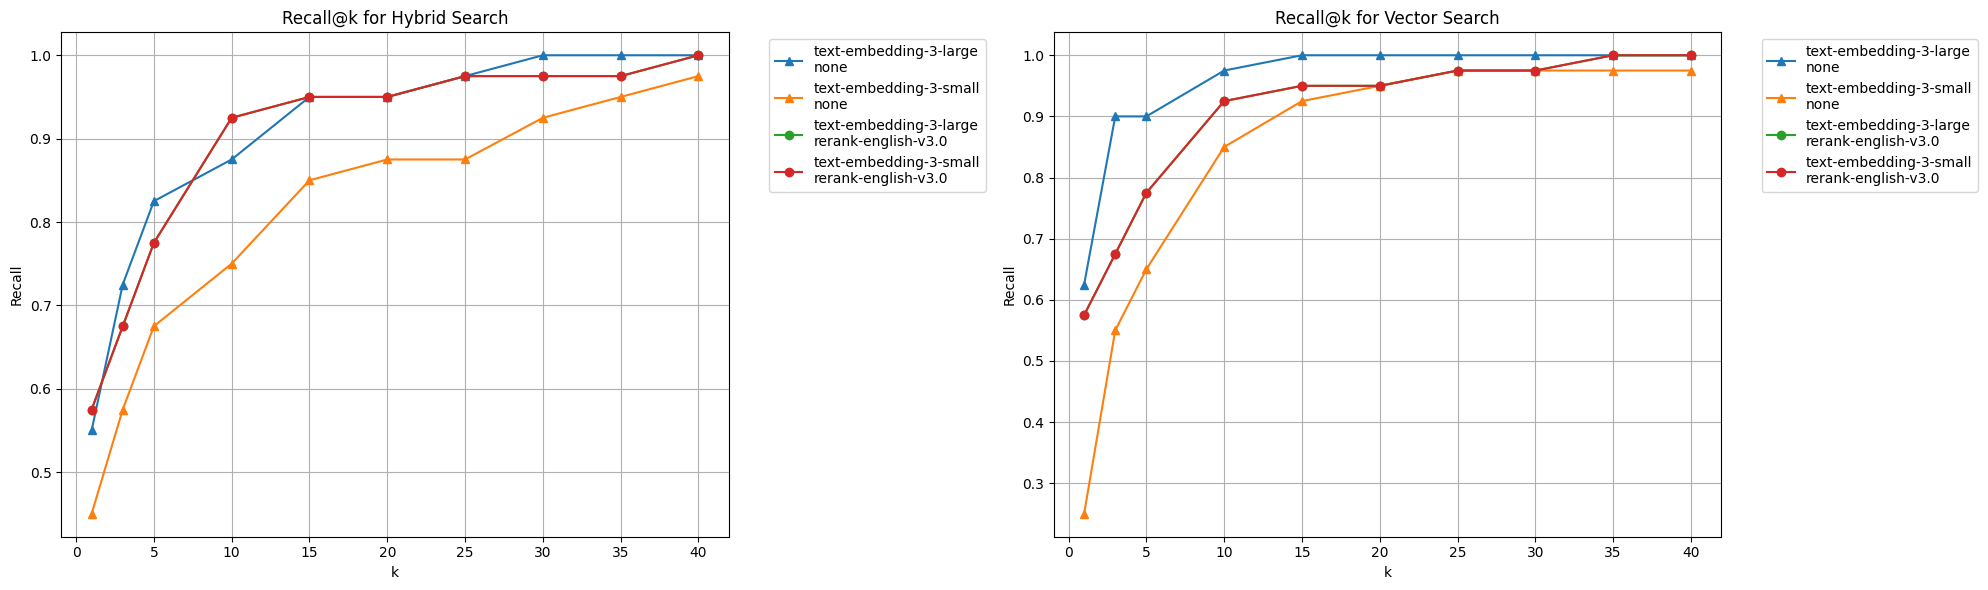

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Sort rerankers and models to ensure consistent order
rerankers = sorted(df["reranker"].unique())
models = sorted(df["embedding_model"].unique())

# Plot for hybrid search
recall_hybrid = df[(df["metric"] == "recall") & (df["query_type"] == "hybrid")]
for reranker in rerankers:
    for model in models:
        data = recall_hybrid[
            (recall_hybrid["reranker"] == reranker)
            & (recall_hybrid["embedding_model"] == model)
        ]

        if len(data) == 0:
            continue

        marker = "o" if reranker != "none" else "^"
        label = f"{model}\n{reranker}"

        ax1.plot(data["k"], data["score"], marker=marker, label=label)

ax1.set_title("Recall@k for Hybrid Search")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot for vector search
recall_vector = df[(df["metric"] == "recall") & (df["query_type"] == "vector")]
for reranker in rerankers:
    for model in models:
        data = recall_vector[
            (recall_vector["reranker"] == reranker)
            & (recall_vector["embedding_model"] == model)
        ]

        if len(data) == 0:
            continue

        marker = "o" if reranker != "none" else "^"
        label = f"{model}\n{reranker}"

        ax2.plot(data["k"], data["score"], marker=marker, label=label)

ax2.set_title("Recall@k for Vector Search")
ax2.set_xlabel("k")
ax2.set_ylabel("Recall")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

There are a few interesting things to note here

1. For Vector Search, the `text-embedding-3-large` model has a higher recall than the `text-embedding-3-small` model even when the reranker is used. 
2. 

In [33]:
# Filter for hybrid search with reranker
hybrid_rerank_df = df[
    (df["metric"] == "recall")
    & (df["query_type"] == "hybrid")
    & (df["reranker"] == "rerank-english-v3.0")
]

# Select key k values and sort by model
summary_df = hybrid_rerank_df[
    hybrid_rerank_df["k"].isin([1, 3, 5, 10, 15, 25, 40])
].sort_values(["embedding_model", "k"])

# Display nicely formatted results
print("\n")
print(summary_df[["metric", "k", "reranker", "embedding_model", "score"]])



    metric   k             reranker         embedding_model  score
30  recall   1  rerank-english-v3.0  text-embedding-3-large  0.575
31  recall   3  rerank-english-v3.0  text-embedding-3-large  0.675
32  recall   5  rerank-english-v3.0  text-embedding-3-large  0.775
33  recall  10  rerank-english-v3.0  text-embedding-3-large  0.925
34  recall  15  rerank-english-v3.0  text-embedding-3-large  0.950
36  recall  25  rerank-english-v3.0  text-embedding-3-large  0.975
39  recall  40  rerank-english-v3.0  text-embedding-3-large  1.000
10  recall   1  rerank-english-v3.0  text-embedding-3-small  0.575
11  recall   3  rerank-english-v3.0  text-embedding-3-small  0.675
12  recall   5  rerank-english-v3.0  text-embedding-3-small  0.775
13  recall  10  rerank-english-v3.0  text-embedding-3-small  0.925
14  recall  15  rerank-english-v3.0  text-embedding-3-small  0.950
16  recall  25  rerank-english-v3.0  text-embedding-3-small  0.975
19  recall  40  rerank-english-v3.0  text-embedding-3-small 

## How many items should we pass into the re-ranker?

We want to know how the performance of the re-ranker changes as we vary the number of items passed into it. This is important because the more items we pass into the re-ranker, the higher the latency.

Therefore, if we can get a good recall@k with a smaller `k`, we should choose that method. Let's modify our earlier code to support this.

We'll be using the text-embedding-3-small model for this experiment with vector search.

In [41]:
from braintrust import init_dataset, Eval
from itertools import product
from lancedb.rerankers import CohereReranker
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions")
][:100]

reranker = CohereReranker(model_name="rerank-english-v3.0", column="query")
experiment_id = str(uuid.uuid4())
embedding_model = "text-embedding-3-small"
search_mode = "vector"
reranker_name = "rerank-english-v3.0"

reranker_results = []
for retrieval_limit in [40, 80, 120]:
    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"reranker-k-comparison-{retrieval_limit}-{experiment_id}",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=table_small,
            mode="vector",
            reranker=reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        reranker_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "score": score_data.score,
                "retrieval_limit": retrieval_limit,
            }
        )

Experiment reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d
Text-2-SQL [experiment_name=reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (data): 100it [00:00, 87018.76it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (tasks):   0%|     …


=========================SUMMARY=========================
reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d compared to reranker-k-comparison-120-b0bfc4b7-316a-42c6-87b6-ae7a90911133:
63.00% (+05.00%) 'mrr@1'     score	(2 improvements, 0 regressions)
67.17% (+02.92%) 'mrr@3'     score	(3 improvements, 0 regressions)
70.02% (+04.17%) 'mrr@5'     score	(6 improvements, 0 regressions)
71.55% (+03.79%) 'mrr@10'    score	(7 improvements, 0 regressions)
71.64% (+03.59%) 'mrr@15'    score	(7 improvements, 0 regressions)
71.64% (+03.59%) 'mrr@20'    score	(7 improvements, 0 regressions)
71.69% (+03.47%) 'mrr@25'    score	(7 improvements, 1 regressions)
71.69% (+03.47%) 'mrr@30'    score	(7 improvements, 1 regressions)
71.72% (+03.48%) 'mrr@35'    score	(8 improvements, 1 regressions)
71.72% (+03.48%) 'mrr@40'    score	(8 improvements, 1 regressions)
63.00% (+05.00%) 'recall@1'  score	(2 improvements, 0 regressions)
72.00% (-) 'recall@3'  score	(0 improvements, 0 regressions)
84.00

Experiment reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d
Text-2-SQL [experiment_name=reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (data): 100it [00:00, 5547.87it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (tasks):   0%|     …


=========================SUMMARY=========================
reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d compared to reranker-k-comparison-40-754aeb9c-5147-43dc-a643-ee3f33bd1b4d:
61.00% (-02.00%) 'mrr@1'     score	(0 improvements, 2 regressions)
65.83% (-01.33%) 'mrr@3'     score	(0 improvements, 4 regressions)
68.13% (-01.88%) 'mrr@5'     score	(0 improvements, 8 regressions)
69.82% (-01.72%) 'mrr@10'    score	(0 improvements, 10 regressions)
69.99% (-01.65%) 'mrr@15'    score	(0 improvements, 10 regressions)
70.05% (-01.59%) 'mrr@20'    score	(1 improvements, 10 regressions)
70.10% (-01.59%) 'mrr@25'    score	(1 improvements, 10 regressions)
70.10% (-01.59%) 'mrr@30'    score	(1 improvements, 10 regressions)
70.13% (-01.59%) 'mrr@35'    score	(1 improvements, 11 regressions)
70.13% (-01.59%) 'mrr@40'    score	(1 improvements, 11 regressions)
61.00% (-02.00%) 'recall@1'  score	(0 improvements, 2 regressions)
72.00% (-) 'recall@3'  score	(0 improvements, 0 regressions)

Experiment reranker-k-comparison-120-754aeb9c-5147-43dc-a643-ee3f33bd1b4d is running at https://www.braintrust.dev/app/567/p/Text-2-SQL/experiments/reranker-k-comparison-120-754aeb9c-5147-43dc-a643-ee3f33bd1b4d
Text-2-SQL [experiment_name=reranker-k-comparison-120-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (data): 100it [00:00, 31172.83it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-120-754aeb9c-5147-43dc-a643-ee3f33bd1b4d] (tasks):   0%|    …


=========================SUMMARY=========================
reranker-k-comparison-120-754aeb9c-5147-43dc-a643-ee3f33bd1b4d compared to reranker-k-comparison-80-754aeb9c-5147-43dc-a643-ee3f33bd1b4d:
61.00% (-) 'mrr@1'     score	(0 improvements, 0 regressions)
65.67% (-00.17%) 'mrr@3'     score	(0 improvements, 1 regressions)
67.97% (-00.17%) 'mrr@5'     score	(0 improvements, 1 regressions)
69.55% (-00.28%) 'mrr@10'    score	(0 improvements, 2 regressions)
69.79% (-00.20%) 'mrr@15'    score	(0 improvements, 3 regressions)
69.79% (-00.26%) 'mrr@20'    score	(0 improvements, 4 regressions)
69.88% (-00.21%) 'mrr@25'    score	(0 improvements, 5 regressions)
69.88% (-00.21%) 'mrr@30'    score	(0 improvements, 5 regressions)
69.91% (-00.22%) 'mrr@35'    score	(0 improvements, 6 regressions)
69.91% (-00.22%) 'mrr@40'    score	(0 improvements, 6 regressions)
61.00% (-) 'recall@1'  score	(0 improvements, 0 regressions)
72.00% (-) 'recall@3'  score	(0 improvements, 0 regressions)
82.00% (-) 'recal

In [46]:
reranker_df = pd.DataFrame(reranker_results)

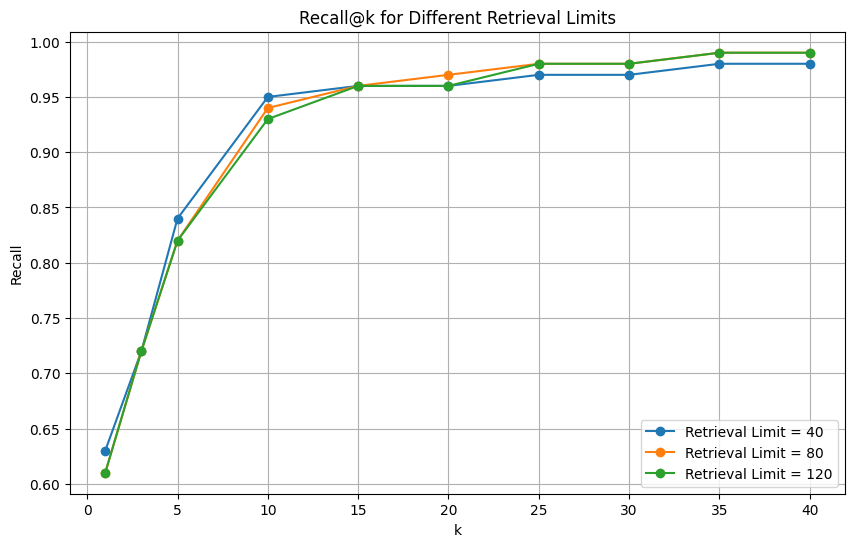

In [43]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "recall"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.show()

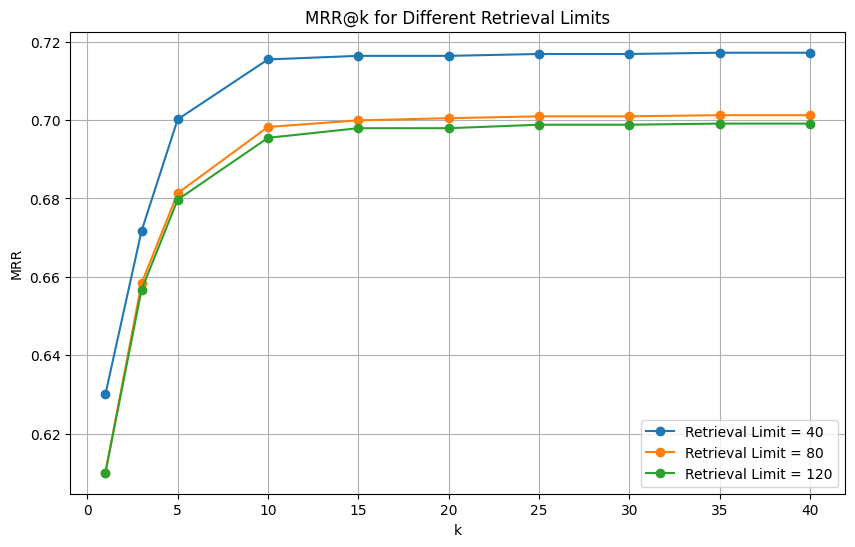

In [45]:
# Filter for mrr metric and create plot
mrr_df = reranker_df[reranker_df["metric"] == "mrr"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = mrr_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("MRR")
plt.title("MRR@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.show()

Now that we've computed the metrics above, we can see that

1. A Re-Ranker improves mrr@k for all query types, especially when k is small. For recall, this improvement is only seen for FTS and Hybrid Search. For embedding search, using a re-ranker resulted in slightly worse performance. This improvement comes at the cost of increased latency of around 300ms, which represents a 60% increase in time needed to retrieve results for a lower recall@10-25.
2. Embedding Search has around 3-13% higher recall than Hybrid Search for all values of k. The two have similar MRR@k for all values of k
3. A Re-Ranker only improves MRR but not recall for embedding search, indicating that the additional latency might not be worth it if MRR is not a priority

What's really surprising in this case is that embedding search alone outperforms hybrid search. Now that we've seen the individual performance, the next step is to do a sensitivity analysis. We do so because we want to make sure the differences we observe are robust and not due to chance. 

This is especially important if implementing these methods will require additional engineering effort. We'll explore some useful techniques such as bootstrapping and t-tests to do so in the next notebook `3. Visualising Results`.
